In [1]:
#########################################################
# Program name: 03_ckdModel.py
# Description: This program builds a CNN-LSTM model for 
# predicting the CKD outcome for a given patient based on
# longitudinal data.
# Input Data : ./input
# Output Data: ./output
#########################################################

In [2]:
## load the required libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, GlobalAveragePooling2D
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer

from keras import applications,models, losses,optimizers
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import numpy as np
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
## Read the data

ckd_data = pd.read_csv('./input/ckd_inputdata.csv')
print(ckd_data.shape)
## Read the stages data
df_stage = pd.read_csv('./dataScienceTask/T_stage.csv')
df_stage.shape

(3865, 32)


(300, 2)

## Data Split

In [4]:
# Split the stages data as it can be used to trace the patient ID later
# 80-20 train test split
train_idx = df_stage.sample(frac=0.8, random_state= 100)
test_idx = df_stage.loc[~df_stage.index.isin(train_idx.index), :]

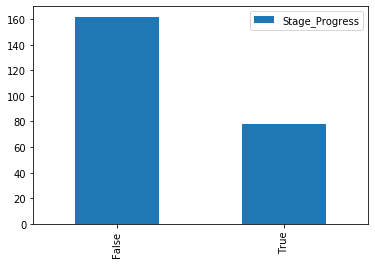

In [5]:
## Training data distribution
df1 = train_idx.set_index('id').apply(pd.value_counts)
df1.plot.bar()

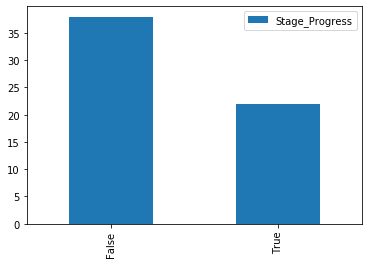

In [6]:
## Test data distribution
df1 = test_idx.set_index('id').apply(pd.value_counts)
df1.plot.bar()

In [7]:
# label_encoder the target variable as it is binary 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'Stage_Progress'. 
trainY = label_encoder.fit_transform(train_idx['Stage_Progress']) 
testY = label_encoder.fit_transform(test_idx['Stage_Progress'])
# 1 = True, 0 False

## Rescale Data

In [21]:
sc=MinMaxScaler(feature_range=(0, 1))

## Training data
X_stdT1 =sc.fit_transform(ckd_data[ckd_data.id.isin(train_idx.id)].drop('id', axis = 1))
X_stdT1 = pd.DataFrame(X_stdT1)
# add ID column back
train_id = ckd_data[ckd_data.id.isin(train_idx.id)][['id']].reset_index()
X_stdT1.insert(0, "id", train_id[['id']])
# Add column names
X_stdT1.columns = ckd_data.columns
## As a padding value replace all NaN with a value that is not common to occur in the data. -1
X_stdT1 = X_stdT1.fillna(0)


## Test data
X_stdT2 =sc.transform(ckd_data[ckd_data.id.isin(test_idx.id)].drop('id', axis = 1))
X_stdT2 = pd.DataFrame(X_stdT2)
# add ID column back
test_id = ckd_data[ckd_data.id.isin(test_idx.id)][['id']].reset_index()
X_stdT2.insert (0, "id", test_id[['id']])
# Add column names
X_stdT2.columns = ckd_data.columns
## As a padding value replace all NaN with a value that is not common to occur in the data. -1 
X_stdT2 = X_stdT2.fillna(0)

In [9]:
X_stdT1

,id,vCreatinine,time,vDBP,vGlucose,vHGB,vLDL,vSBP,atorvastatin_dose,losartan_dose,...,canagliflozin_dose,dapagliflozin_dose,telmisartan_dose,labetalol_dose,nebivolol_dose,pitavastatin_dose,propranolol_dose,race,gender,age
0,1,0.539568,0.000000,0.38541,0.492754,0.546926,0.367963,0.549706,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.625
1,1,0.571942,0.097282,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,0.166667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.625
2,1,0.564748,0.413448,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.625
3,1,0.492806,0.553648,-1.00000,-1.000000,0.601942,-1.000000,-1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.625
4,1,0.705036,0.672389,-1.00000,-1.000000,0.646170,-1.000000,-1.000000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,293,-1.000000,0.278970,-1.00000,-1.000000,-1.000000,0.359615,-1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.650
3083,293,-1.000000,0.739628,-1.00000,-1.000000,-1.000000,0.191779,-1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.650
3084,299,-1.000000,0.769671,-1.00000,-1.000000,-1.000000,0.273523,-1.000000,0.083333,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.950
3085,174,-1.000000,0.862661,-1.00000,-1.000000,-1.000000,-1.000000,0.377834,0.000000,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.850


## Reshape data

In [22]:
# Shape the Patient data into the desired input format for CNN 
# convert each patient ID information to a 32 * 32 image
## Prepare the training data
trainX = []

for i in train_idx.id:
    sub_data = X_stdT1[X_stdT1.id == i]
    # change the ID value to 0
    # Not dropping the ID column, instead fill it with 0 value to act as a dummy variable and keep the dimension as 32 columns
    sub_data['id'] = 0
    ## Adding dummy rows
    for x in range(32 - sub_data.shape[0]):
        sub_data = sub_data.append(pd.Series([0, 0, 0, 0, 0, 0, 0,
                                             0, 0, 0, 0, 0, 0, 0,
                                             0, 0, 0, 0, 0, 0, 0, 0,
                                             0, 0, 0, 0, 0, 0, 0,0, 0, 0], 
                                             index=sub_data.columns) , ignore_index=True)
    t1 = np.array(sub_data.values)
    
    t2 = t1.reshape(32, 32, 1)
    trainX.append(t2)

trainX = np.array(trainX)
trainX = np.reshape(trainX,(trainX.shape[0],32,32,1))
print("Training data shape:", trainX.shape, trainY.shape)

C:\Users\ramesind\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Training data shape: (240, 32, 32, 1) (240,)


In [23]:
## Prepare the training data
testX = []

for i in test_idx.id:
    sub_data = X_stdT2[X_stdT2.id == i]
    # change the ID value to 0
    sub_data['id'] = 0
    ## Adding dummy rows
    for x in range(32 - sub_data.shape[0]):
        sub_data = sub_data.append(pd.Series([0, 0, 0, 0, 0, 0, 0,
                                             0, 0, 0, 0, 0, 0, 0,
                                             0, 0, 0, 0, 0, 0, 0, 0,
                                             0, 0, 0, 0, 0, 0, 0,0, 0, 0], 
                                             index=sub_data.columns) , ignore_index=True)
    t1 = np.array(sub_data.values)
    
    t2 = t1.reshape(32, 32, 1)
    testX.append(t2)

testX = np.array(testX)
testX = np.reshape(testX,(testX.shape[0],32,32,1))

print("Test data shape:", testX.shape, testY.shape)

C:\Users\ramesind\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Test data shape: (60, 32, 32, 1) (60,)


## Build Model

In [52]:
## Define custom metrics
import tensorflow as tf

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
from keras import backend as K
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [74]:
np.random.seed(109) # for reproducibility
print('Building model...')
model = Sequential()


#1st conv layer
model.add(Conv2D(32, (3,3), padding="same", activation = 'relu',
                 input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3])))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())


#2nd conv layer
model.add(Conv2D(16, (3,3), padding="same", activation = 'relu'))


#3rd conv layer
model.add(Conv2D(16, (3,3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#3rd conv layer
model.add(Conv2D(16, (3,3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#4th conv layer
model.add(Conv2D(64, (3,3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())


model.add(GlobalAveragePooling2D())

#Fully connected layer 1
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#Fully connected layer 2
model.add(Dense(100,name ='feature_dense', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

#output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))
adam = optimizers.Adam(lr=0.0001)

model.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m, recall_m, auc],
              optimizer='adam')
model.summary()

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 8, 16)          64 

In [75]:
batch_size = 16
epochs = 100
early_stops = EarlyStopping(patience= 50 , monitor='val_auc')
filepath='ckd_model_conv2D.h5'
ckpt_callback = ModelCheckpoint(filepath,
                                 monitor='val_auc',
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')
    
ckd_mdl = model.fit(trainX, trainY, validation_split=0.1, callbacks=[early_stops,ckpt_callback], 
                        batch_size=batch_size, epochs=epochs)
#model.save('ckd_model_conv2D.h5')

Train on 216 samples, validate on 24 samples
Epoch 1/100
216/216 [==============================] - 4s 21ms/step - loss: 1.0241 - acc: 0.5324 - f1_m: 0.4303 - recall_m: 0.5944 - auc: 0.5091 - val_loss: 1.1795 - val_acc: 0.3333 - val_f1_m: 0.2619 - val_recall_m: 0.4444 - val_auc: 0.4889

Epoch 00001: val_auc improved from -inf to 0.48888, saving model to ckd_model_conv2D.h5
Epoch 2/100
216/216 [==============================] - 0s 2ms/step - loss: 0.8167 - acc: 0.5278 - f1_m: 0.3569 - recall_m: 0.4345 - auc: 0.5168 - val_loss: 1.1028 - val_acc: 0.4167 - val_f1_m: 0.4000 - val_recall_m: 0.7778 - val_auc: 0.5110

Epoch 00002: val_auc improved from 0.48888 to 0.51097, saving model to ckd_model_conv2D.h5
Epoch 3/100
216/216 [==============================] - 0s 2ms/step - loss: 0.7511 - acc: 0.5741 - f1_m: 0.4487 - recall_m: 0.5710 - auc: 0.5256 - val_loss: 0.7952 - val_acc: 0.5833 - val_f1_m: 0.2667 - val_recall_m: 0.2222 - val_auc: 0.5339

Epoch 00003: val_auc improved from 0.51097 to 0.5


Epoch 00025: val_auc improved from 0.70673 to 0.71167, saving model to ckd_model_conv2D.h5
Epoch 26/100
216/216 [==============================] - 1s 2ms/step - loss: 0.4115 - acc: 0.7824 - f1_m: 0.6620 - recall_m: 0.7160 - auc: 0.7156 - val_loss: 1.2159 - val_acc: 0.3750 - val_f1_m: 0.1111 - val_recall_m: 0.1111 - val_auc: 0.7175

Epoch 00026: val_auc improved from 0.71167 to 0.71747, saving model to ckd_model_conv2D.h5
Epoch 27/100
216/216 [==============================] - 0s 2ms/step - loss: 0.4078 - acc: 0.8056 - f1_m: 0.7022 - recall_m: 0.7240 - auc: 0.7213 - val_loss: 1.1813 - val_acc: 0.5000 - val_f1_m: 0.1333 - val_recall_m: 0.1111 - val_auc: 0.7229

Epoch 00027: val_auc improved from 0.71747 to 0.72291, saving model to ckd_model_conv2D.h5
Epoch 28/100
216/216 [==============================] - 0s 2ms/step - loss: 0.3893 - acc: 0.8241 - f1_m: 0.7018 - recall_m: 0.6844 - auc: 0.7259 - val_loss: 0.7942 - val_acc: 0.6667 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_au

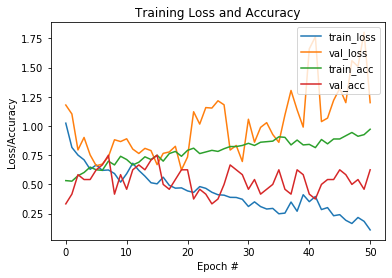

In [76]:
plt.figure()
N = 51
plt.plot(np.arange(0, N), ckd_mdl.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), ckd_mdl.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), ckd_mdl.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), ckd_mdl.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [77]:
## Load the model and perform prediction on test data
from keras.models import load_model
saved_model = load_model('./output/ckd_model_conv2D.h5', custom_objects={'f1_m': f1_m, 'recall_m': recall_m, 'auc': auc })
pred_Y = saved_model.predict(testX, batch_size = batch_size, verbose = True)

60/60 [==============================] - 1s 20ms/step


In [223]:
# pred_bool = pred > 0.4
# labels = pred_bool.astype("int32")
# label_predictions.append(labels)

[[26 12]
 [ 8 14]]


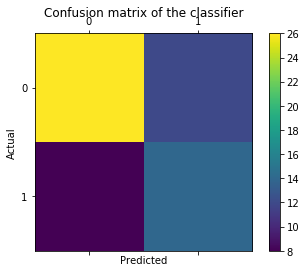

In [78]:
## Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
labs = [0,1]
cm1 = confusion_matrix(testY,np.round(pred_Y))
print(cm1)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm1)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labs)
ax.set_yticklabels([''] + labs)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [79]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(testY, np.round(pred_Y))

classification_report = metrics.classification_report(testY, np.round(pred_Y))
print(confusion_matrix)
print(classification_report)

[[26 12]
 [ 8 14]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        38
           1       0.54      0.64      0.58        22

    accuracy                           0.67        60
   macro avg       0.65      0.66      0.65        60
weighted avg       0.68      0.67      0.67        60



In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(testY, np.round(pred_Y))

0.6666666666666666

## ROC curve

In [81]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(testX).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, np.round(pred_Y))

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

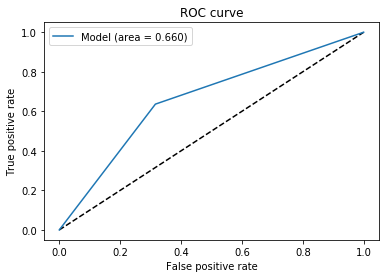

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()